# Evaluate LensKit recommender algorithms on S&co interactions data

Notebook for nDCG evaluation with LensKit for Python; adapted from https://lkpy.lenskit.org/en/stable/GettingStarted.html

## Setup

We first need to install LensKit:

In [ ]:
%%capture
%pip install lenskit

Now we can import LensKit utilities:

In [1]:
from lenskit.datasets import ML100K
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn as knn, user_knn, basic, tf
from lenskit import topn

## Loading Data

Now we need to load the data we want to use for the recommender.

Load S&co datasets and pull out member/book borrowing interactions to use as our "ratings" dataset.


In [ ]:
import pandas as pd

# get shxco datasets
csv_urls = {
    'members': 'https://dataspace.princeton.edu/bitstream/88435/dsp01b5644v608/2/SCoData_members_v1.1_2021-01.csv',
    'books': 'https://dataspace.princeton.edu/bitstream/88435/dsp016d570067j/2/SCoData_books_v1.1_2021-01.csv',
    'events': 'https://dataspace.princeton.edu/bitstream/88435/dsp012n49t475g/2/SCoData_events_v1.1_2021-01.csv'

}

# load members, books, events as csv
members_df = pd.read_csv(csv_urls['members'])
books_df = pd.read_csv(csv_urls['books'])
events_df = pd.read_csv(csv_urls['events'])

In [ ]:
# split multiple members for shared accounts in events
events_df[
    ["first_member_uri", "second_member_uri"]
] = events_df.member_uris.str.split(";", expand=True)

# working with the first member for now...
# generate short ids equivalent to those in member and book dataframes
events_df["member_id"] = events_df.first_member_uri.apply(
    lambda x: x.split("/")[-2]
)
events_df["item_id"] = events_df.item_uri.apply(
    lambda x: x.split("/")[-2] if pd.notna(x) else None
)

# get all member-book interactions from events
# shorten URIs for readability in output
interactions_df = events_df[events_df.item_uri.notna()].copy()

# restrict to borrow events only
interactions_df = interactions_df[interactions_df.event_type == 'Borrow'].copy()

# some algorithms can make use of timestamp; not sure which ones or if this format will work
interactions_df['start_date_dt'] = pd.to_datetime(interactions_df['start_date'], errors='coerce')

# reduce to minimum user/item interaction fields and drop dupes
unique_interactions_df = interactions_df[
    ["member_id", "item_id", "start_date_dt"]
].drop_duplicates(subset=["member_id", "item_id"])

# rename to columns expected by lenskit; rename to ratings for use with tutorial
ratings = unique_interactions_df.rename(columns={'member_id': 'user', 'item_id': 'item', 'start_date_dt': 'timestamp'})

# example assumes rating; use 1/0 rating, set all to 1 to confirm interaction
ratings['rating'] = 1

ratings.head(10)

,user,item,timestamp,rating
7359,joyce-james,smollett-expedition-humphry-clinker,NaT,1
7393,hommel,joyce-pomes-penyeach,NaT,1
7394,hommel,city-dreadful-night,NaT,1
7395,hommel,wilson-axels-castle-study,NaT,1
7396,hommel,cowley-exiles-return-narrative,NaT,1
7397,hommel,heine-heines-poems,NaT,1
7425,bernheim-antoinette,forster-passage-india,NaT,1
7444,rhys,conrad-typhoon,1922-01-01,1
7452,tery,james-joyce,1924-01-01,1
7453,tery,freeman-portrait-george-moore,1924-01-01,1


## Defining Algorithms

Let's define the algorithms we want to test:

In [ ]:
# install implicit package so we can try those algorithms
!pip install implicit

     |████████████████████████████████| 1.1 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for implicit: filename=implicit-0.4.8-cp37-cp37m-linux_x86_64.whl size=4606579 sha256=7cf42491875c1d0f10e130be8ea7bf3d32932f0f3a124e73ef6523012c1b04f1
  Stored in directory: /root/.cache/pip/wheels/88/e6/34/25e73cccbaf1a961154bb562a5f86123b68fdbf40e306073d6
Successfully built implicit


In [ ]:
from  lenskit.algorithms import implicit 

# define the algorithms we want to test in a dict with labels, so we can 
# add and adjust what we want to test here
algos = {
  'ItemItem': knn.ItemItem(50, center=False, aggregate='sum'),  # was previously not generating any results; now working?
  # 'UserUser': user_knn.UserUser(50),   # not generating results either
  'ALS': als.BiasedMF(50),
  'ALS iMF': als.ImplicitMF(50, use_ratings=False),
  'TF BiasedMF': tf.BiasedMF(50),
  'TF BPR': tf.BPR(50),
  # 'Implicit BPR': implicit.BPR(50),  # Cuda error :-( 
  'Popular': basic.Popular(),
  'Random': basic.Random(),
}

## Running the Evaluation

In LensKit, our evaluation proceeds in 2 steps:

1. Generate recommendations
2. Measure them

If memory is a concern, we can measure while generating, but we will not do that for now.

We will first define a function to generate recommendations from one algorithm over a single partition of the data set.  It will take an algorithm, a train set, and a test set, and return the recommendations.

**Note:** before fitting the algorithm, we clone it.  Some algorithms misbehave when fit multiple times.

**Note 2:** our algorithms do not necessarily implement the `Recommender` interface, so we adapt them. This fills in a default candidate selector.

The code function looks like this:

In [ ]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

Now, we will loop over the data and the algorithms, and generate recommendations:

In [ ]:
all_recs = []
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating', 'timestamp']], 5, xf.SampleFrac(0.2)):
    test_data.append(test)
    # for each algo defined in our dict above, evaulate and append results
    for algo_name, algo in algos.items():
          all_recs.append(eval(algo_name, algo, train, test))  

    # all_recs.append(eval('ItemItem', algo_ii, train, test))  
    # all_recs.append(eval('UserUser', algo_uu, train, test))  
    # all_recs.append(eval('ALS', algo_als, train, test))
    # all_recs.append(eval('ALS_iMF', algo_alsimf, train, test))
    # all_recs.append(eval('TF BiasedMF', algo_tfbiasmd, train, test))
    # all_recs.append(eval('TF BPR', algo_tfbpr, train, test))
    # all_recs.append(eval('Random', random, train, test))
    # # all_recs.append(eval('implicit_base', algo_implicit, train, test))


Epoch 1/5
2/2 [==============================] - 1s 19ms/step - loss: 0.0053
Epoch 2/5
2/2 [==============================] - 0s 18ms/step - loss: 0.0051
Epoch 3/5
2/2 [==============================] - 0s 16ms/step - loss: 0.0050
Epoch 4/5
2/2 [==============================] - 0s 23ms/step - loss: 0.0048
Epoch 5/5
2/2 [==============================] - 0s 20ms/step - loss: 0.0046
Epoch 1/5
2/2 [==============================] - 1s 25ms/step - loss: 0.6982
Epoch 2/5
2/2 [==============================] - 0s 28ms/step - loss: 0.6977
Epoch 3/5
2/2 [==============================] - 0s 29ms/step - loss: 0.6970
Epoch 4/5
2/2 [==============================] - 0s 25ms/step - loss: 0.6963
Epoch 5/5
2/2 [==============================] - 0s 25ms/step - loss: 0.6958
Epoch 1/5
2/2 [==============================] - 1s 19ms/step - loss: 0.0053
Epoch 2/5
2/2 [==============================] - 0s 16ms/step - loss: 0.0052
Epoch 3/5
2/2 [==============================] - 0s 16ms/step - loss: 0.0050

With the results in place, we can concatenate them into a single data frame:

In [ ]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs.head()

,item,score,user,rank,Algorithm
0,mason-washington-legation-murders,1.508962,baldwin-helen-green,1,ItemItem
1,christie-thirteen-dinner,1.469200,baldwin-helen-green,2,ItemItem
2,tomlinson-snows-helicon,1.438492,baldwin-helen-green,3,ItemItem
3,queen-roman-hat-mystery,1.341190,baldwin-helen-green,4,ItemItem
4,wharton-human-nature,1.274274,baldwin-helen-green,5,ItemItem


To compute our analysis, we also need to concatenate the test data into a single frame:

In [ ]:
test_data = pd.concat(test_data, ignore_index=True)

We analyze our recommendation lists with a `RecListAnalysis`.  It takes care of the hard work of making sure that the truth data (our test data) and the recoommendations line up properly.

We do assume here that each user only appears once per algorithm. Since our crossfold method partitions users, this is fine.

In [ ]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(all_recs, test_data)
results.head()

nrecs      ndcg
Algorithm user                                
ItemItem  baldwin-helen-green    100  0.077406
          bernheim               100  0.021993
          bernheim-antoinette    100  0.036162
          bernheim-francoise     100  0.000000
          bremond                100  0.039007

Now we have nDCG values!

In [ ]:
results.groupby('Algorithm').ndcg.mean()

Algorithm
ALS            0.004434
ALS iMF        0.076177
ItemItem       0.034903
Popular        0.053541
Random         0.006152
TF BPR         0.005444
TF BiasedMF    0.004969
Name: ndcg, dtype: float64

Adn we can plot them:

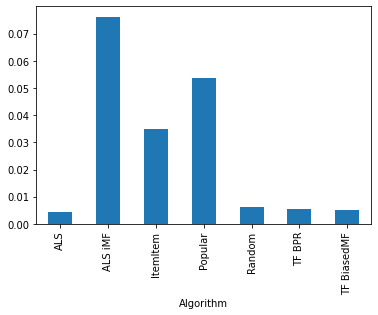

In [ ]:
results.groupby('Algorithm').ndcg.mean().plot.bar()